# Knowledge-Graph-Based Retrieval Augmented Generation for FSU Search

#### The problem
The search functionality on fsu.edu sites is fragmented and cumbersome. Its functionality reflects none of the recent advancements in natural language processing - specifically, Large Language Models and the ability to intelligently and naturally respond to queries.

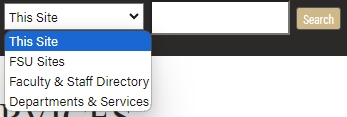

We seek to do two main modifications:
1. combine these searches into one, providing only an option to limit to the current site.
2. Wield the power of Large Language Models to allow for conversational or question/answer capability using direct information from FSU's databases and websites.

It is with these requirements that we present a possible solution:
**Combining the power of knowledge graphs, a powerful way to represent relational data, and Retrieval Augmented Generation (RAG), a technique for informing Language Models with real data, we can make a powerful pairing that allows for users to get information about FSU faculty, staff, departments, buildings, events, classes, and more.**

let's explore how we do this.

#### Making the knowledge graph

In [4]:
%pip install --upgrade --quiet  langchain langchain-community langchain-openai langchain-experimental neo4j wikipedia tiktoken yfiles_jupyter_graphs pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1 -> 24.0
[notice] To update, run: C:\Users\shont\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [5]:
from dotenv import load_dotenv
import os

from langchain_community.graphs import Neo4jGraph

# Warning control
import warnings
warnings.filterwarnings("ignore")

##### Reading in Faculty and Staff Data

In [6]:
# Load from environment
load_dotenv('.env', override=True)
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
NEO4J_DATABASE = os.getenv('NEO4J_DATABASE')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

##### Creating Knowledge Graph

In [7]:
# Connect to the knowledge graph instance using LangChain
kg = Neo4jGraph(
    url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD, database=NEO4J_DATABASE
)

ValueError: Cannot resolve address 21508317.databases.neo4j.io:7687

##### Reading in Departments and Services Data

In [ ]:
import pandas as pd

depts = pd.read_csv("data/Dept_Address_URL.csv")
fac_staff = pd.read_csv("data/Fac and Staff Directory.csv")

##### Updating Knowledge Graph

In [ ]:
import ScrapingUtils as SU

##### Crawling FSU Websites

##### Updating Knowledge Graph

In [ ]:
kg.query("""
  CREATE VECTOR INDEX movie_tagline_embeddings IF NOT EXISTS
  FOR (m:Movie) ON (m.taglineEmbedding) 
  OPTIONS { indexConfig: {
    `vector.dimensions`: 1536,
    `vector.similarity_function`: 'cosine'
  }}"""
)

kg.query("""
  SHOW VECTOR INDEXES
  """
)

#### Retrieval

In [ ]:
kg.query("""
    MATCH (movie:Movie) WHERE movie.tagline IS NOT NULL
    WITH movie, genai.vector.encode(
        movie.tagline, 
        "OpenAI", 
        {
          token: $openAiApiKey,
          endpoint: $openAiEndpoint
        }) AS vector
    CALL db.create.setNodeVectorProperty(movie, "taglineEmbedding", vector)
    """, 
    params={"openAiApiKey":OPENAI_API_KEY, "openAiEndpoint": OPENAI_ENDPOINT} )

result = kg.query("""
    MATCH (m:Movie) 
    WHERE m.tagline IS NOT NULL
    RETURN m.tagline, m.taglineEmbedding
    LIMIT 1
    """
)

#### Feeding into a language model

#### Question and answer

In [ ]:
question = "What movies are about love?"

In [ ]:
kg.query("""
    WITH genai.vector.encode(
        $question, 
        "OpenAI", 
        {
          token: $openAiApiKey,
          endpoint: $openAiEndpoint
        }) AS question_embedding
    CALL db.index.vector.queryNodes(
        'movie_tagline_embeddings', 
        $top_k, 
        question_embedding
        ) YIELD node AS movie, score
    RETURN movie.title, movie.tagline, score
    """, 
    params={"openAiApiKey":OPENAI_API_KEY,
            "openAiEndpoint": OPENAI_ENDPOINT,
            "question": question,
            "top_k": 5
            })